In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import astra
import pywt

from tqdm import tqdm

%matplotlib inline

# PART A

#### 1. Calculate the Radon transform of an image and test the back-projection method.

##### Load $f_{\text{true}}$

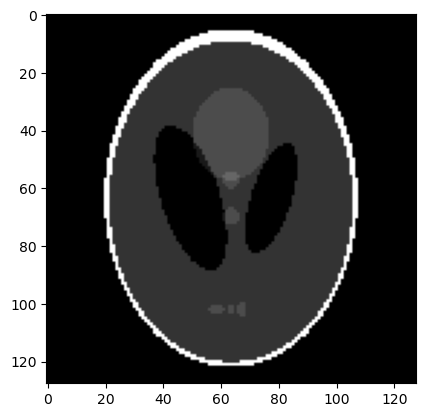

In [53]:
# Load data
SLphantom = np.load('data/SLphan.npy')

f_true = SLphantom
plt.imshow(f_true, cmap='gray')

##### Generate the Radon transform $g=Rf$

In [3]:
def Randon_Transform(f, det_count=128, angle_count=180, max_angle=np.pi):
    # Create volume geometries
    v, h = f.shape
    vol_geom = astra.create_vol_geom(v, h)

    # Create projector geometries

    detector_spacing = 1.
    # det_count = int(v / detector_spacing)
    angles = np.linspace(0, max_angle, angle_count, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, det_count, angles)

    # Create projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Radon transform (generate sinogram)
    sinogram_id, sinogram = astra.create_sino(f, projector_id)

    return vol_geom, proj_geom, projector_id, sinogram_id, sinogram

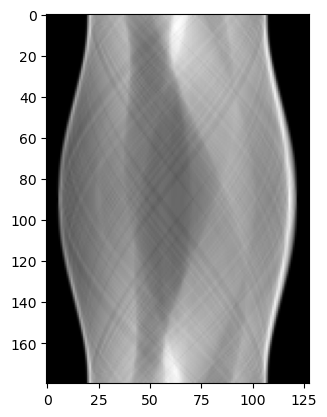

In [4]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true)
plt.imshow(g, cmap='gray')

##### Compute $unfiltered$ back-projection

In [5]:
def Radon_Back_Proj(vol_geom, sinogram_id, projector_id, ptype='BP'):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(ptype)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

l2 distance:  376814.3861678726


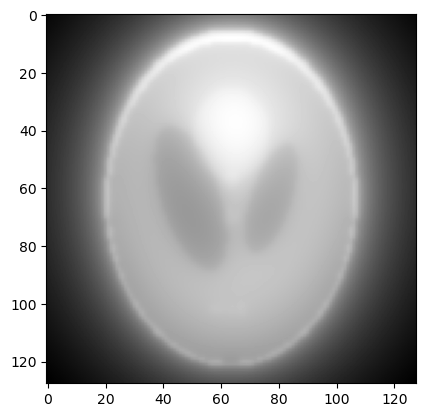

In [6]:
f_rec = Radon_Back_Proj(vol_geom, g_id, proj_id)
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(f_rec, cmap='gray')

##### Compute $filtered$ back-projection

l2 distance:  7.360654329544242


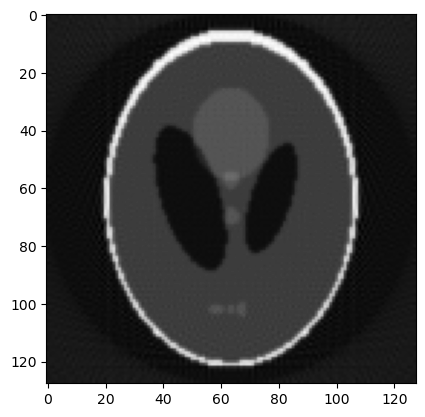

In [7]:
f_filtered_rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
print('l2 distance: ', np.linalg.norm(f_filtered_rec - f_true))
plt.imshow(f_filtered_rec, cmap='gray')

##### Add noise to the data $g$

In [8]:
def add_noise_to_sino(proj_geom, sinogram, theta=1.0):
    sinogram_noisy = astra.functions.add_noise_to_sino(sinogram, theta)
    sinogram_noisy_id = astra.data2d.create('-sino', proj_geom, sinogram_noisy)
    return sinogram_noisy_id, sinogram_noisy

In [9]:
# noises = np.linspace(20, 10000, num=100)
noises = np.logspace(1, 2.86, base=25, num=100)
g_l2ds = []
g_vars = []
rec_l2ds = []
vol_geom, proj_geom, proj_id, sinogram_id, sinogram = Randon_Transform(f_true)
for noise in tqdm(noises):
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, sinogram, theta=noise)
    g_l2ds.append(np.linalg.norm(g_noisy - sinogram))
    g_vars.append(np.var(g_noisy - sinogram))
    f_noisy_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, ptype='FBP')
    rec_l2ds.append(np.linalg.norm(f_noisy_rec - f_true))

  0%|          | 0/100 [00:00<?, ?it/s]/Users/lucien/opt/anaconda3/lib/python3.9/site-packages/astra/functions.py:115: RuntimeWarning: divide by zero encountered in log
  sinogram_out = -max_sinogramRaw * np.log(sinogramCT_D)
/Users/lucien/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 100/100 [00:05<00:00, 18.50it/s]


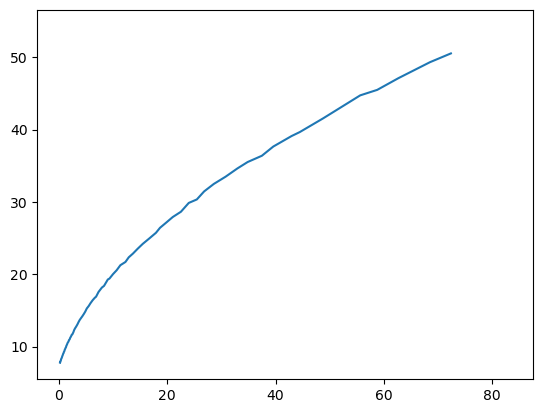

In [10]:
plt.plot(g_vars, rec_l2ds)

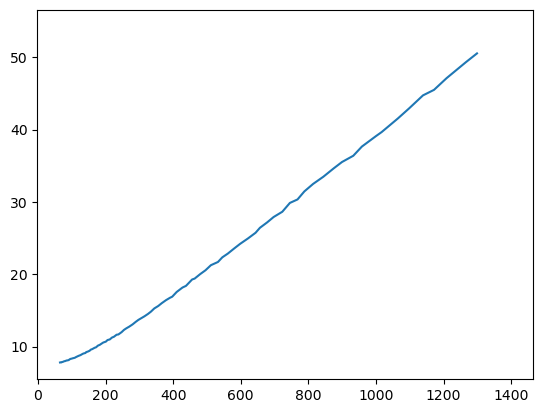

In [11]:
plt.plot(g_l2ds, rec_l2ds)

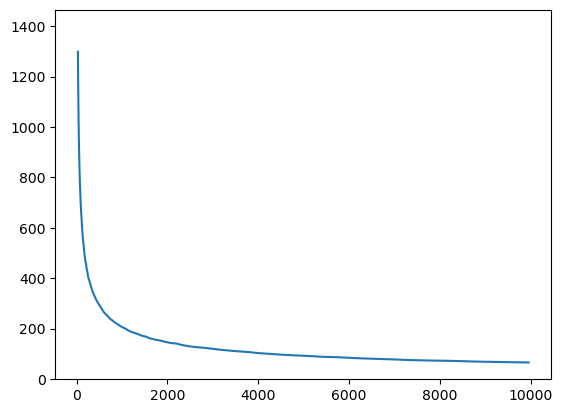

In [12]:
plt.plot(noises, g_l2ds)

#### 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.

##### Construct explicit matrix of Radon Transform

In [13]:
def construct_Radon_Matrix(h, w, n_angles, max_angle, n_projs):
    
    f = np.zeros((h, w))
    n_pixels = h * w
    R = np.zeros((n_angles * n_projs, n_pixels))
    for i in tqdm(range(n_pixels)):
        r = i // w
        c = i % w
        f[r, c] = 1
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f, det_count=n_projs, angle_count=n_angles, max_angle=max_angle)
        R[:, i] = g.reshape((n_angles * n_projs,))
        f[r, c] = 0
    
    return R

def apply_Radon_Matrix(R, im, n_angles, n_projs):
    h, w = im.shape
    return (R @ im.reshape((h * w))).reshape((n_angles, n_projs))

In [14]:
R = construct_Radon_Matrix(128, 128, 10, np.pi, 128)

100%|██████████| 16384/16384 [00:37<00:00, 440.18it/s]


In [15]:
R45 = construct_Radon_Matrix(128, 128, 10, np.pi / 4, 128)

100%|██████████| 16384/16384 [00:36<00:00, 444.62it/s]


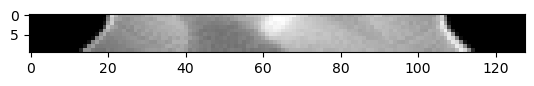

In [16]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, det_count=128, angle_count=10, max_angle=np.pi/4)
plt.imshow(g, cmap='gray')

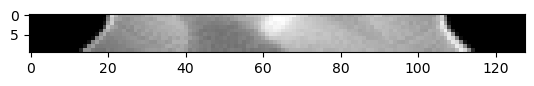

In [17]:
plt.imshow(apply_Radon_Matrix(R45, f_true, 10, 128), cmap='gray')

##### SVD analysis

$\text{i)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:4:179]$

In [18]:
R1 = construct_Radon_Matrix(64, 64, 45, np.pi, 45)

100%|██████████| 4096/4096 [00:09<00:00, 426.30it/s]


In [19]:
U1, s1, Vh1 = scipy.linalg.svd(R1)

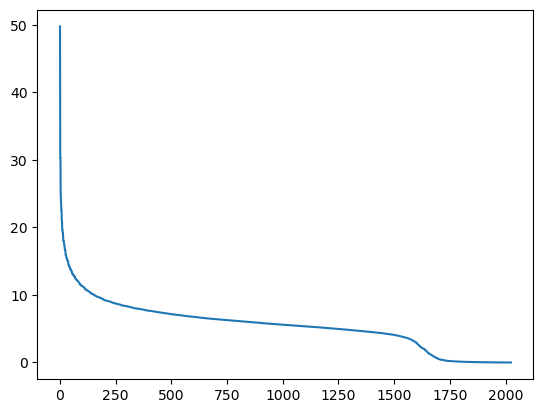

In [20]:
plt.plot(s1)

$\text{ii)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:1:44]$

In [21]:
R2 = construct_Radon_Matrix(64, 64, 45, np.pi/4, 45)

100%|██████████| 4096/4096 [00:09<00:00, 434.63it/s]


In [22]:
U2, s2, Vh2 = scipy.linalg.svd(R2)

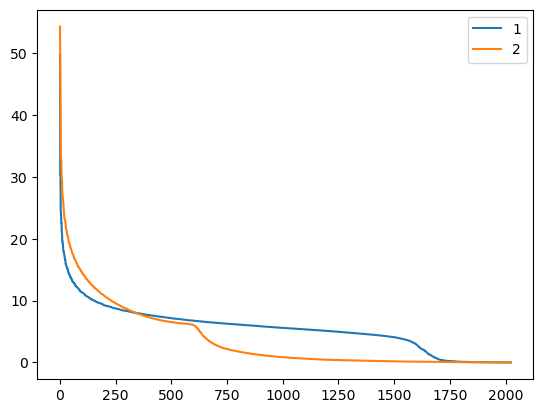

In [23]:
plt.plot(s1, label='1')
plt.plot(s2, label='2')
plt.legend()

#### 3. Implement a matrix-free regularised least-squares solver for the Radon Transform.

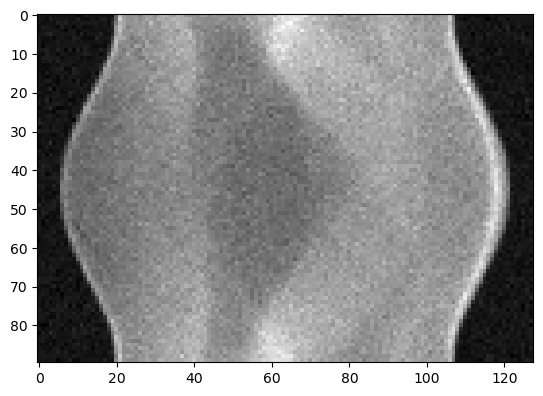

In [55]:
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, 128, 90)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(g_noisy, cmap='gray')

l2 distance:  13.729606920333197


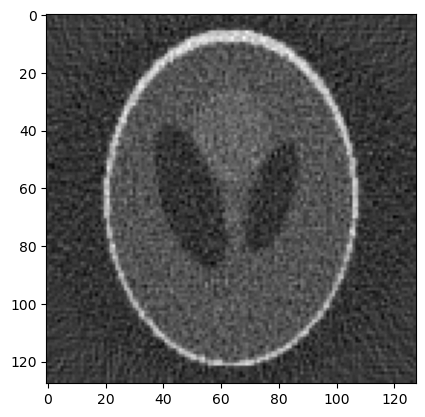

In [56]:
f_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, 'FBP')
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(f_rec, cmap='gray')

In [57]:
def construct_Radon_Operator(h, w, n_projs, n_angles, max_angle):

    def forward(v):
        im = v.reshape((h, w))
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(im, n_projs, n_angles, max_angle)
        return g.reshape((n_projs * n_angles,))

    def backward(v):
        g = v.reshape((n_angles, n_projs))
        vol_geom = astra.create_vol_geom(h, w)
        angles = np.linspace(0, max_angle, n_angles, endpoint=False)
        proj_geom = astra.create_proj_geom('parallel', 1., n_projs, angles)
        projector_id = astra.create_projector('strip', proj_geom, vol_geom)
        _, back_projection = astra.create_backprojection(g, projector_id, returnData=True)
        return back_projection.reshape((h * w,))

    return scipy.sparse.linalg.LinearOperator((n_projs * n_angles, h * w), matvec=forward, rmatvec=backward)

In [58]:
R_op = construct_Radon_Operator(128, 128, 128, 90, np.pi)
# R_op = construct_Radon_Operator(128, 128, 128, 180, np.pi / 2)
# g_op = apply_Radon_Matrix(R_op, f_true, 90, 128)

In [28]:
def apply_Radon_Back_Projection_Matrix(Rt, g, h, w):
    n_angles, n_projs = g.shape
    return (Rt @ g.reshape((n_angles * n_projs))).reshape((h, w))

In [29]:
def solve_with_l2_reg(alpha, A, g):
    def M_f(v):
        Af = A @ v
        If = np.sqrt(alpha) * v
        z = np.hstack((Af, If))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        Itf = np.sqrt(alpha) * v[h:]
        z = Atf + Itf
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [30]:
gh, gw = g_noisy.shape
x_lsqr = solve_with_l2_reg(100, R_op, g_noisy.reshape((gh * gw)))

Status: 2
Iteration number: 32

l2 distance:  12.003292829195138


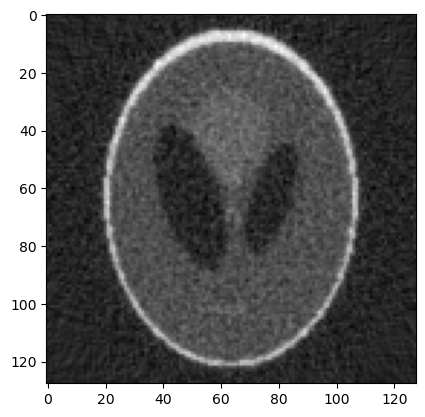

In [31]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

0.006645027796427409 1.3568467199833762
145.48726


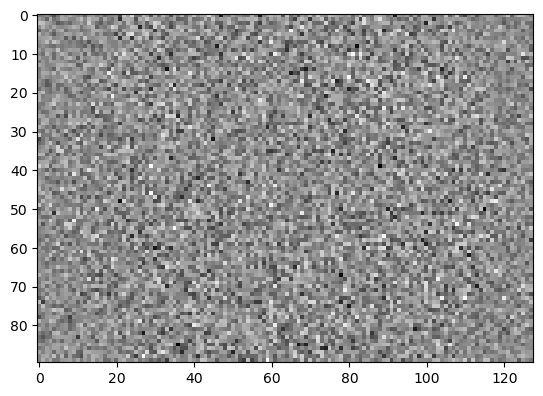

In [32]:
noise_matrix = g_noisy - grt
n = noise_matrix.shape[0] * noise_matrix.shape[1]
mu = np.sum(noise_matrix) / n
sig = np.sqrt(np.sum(np.power(noise_matrix - mu, 2)) / (n - 1))
print(mu, sig)
Af = apply_Radon_Matrix(R_op, f_rec_lsqr, 90, 128)
plt.imshow(grt - g_noisy, cmap='gray')
print(np.linalg.norm(Af - g_noisy))

In [33]:
def dp_alpha(alpha, sig, h, w, n_angles, n_projs):
    gh, gw = g_noisy.shape
    x_lsqr = solve_with_l2_reg(alpha, R_op, g_noisy.reshape((gh * gw)))
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(R_op, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g_noisy)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return dp_alpha
sol = scipy.optimize.root(dp_alpha, x0=1, args=(sig, f_true.shape[0], f_true.shape[1], 90, 128))

    fjac: array([[-1.]])
     fun: -1.0323537580347875e-07
 message: 'The solution converged.'
    nfev: 23
     qtf: array([1.03235376e-07])
       r: array([0.])
  status: 1
 success: True
       x: array([100.23307205])
Status: 2
Iteration number: 32

l2 distance:  12.006547887775996


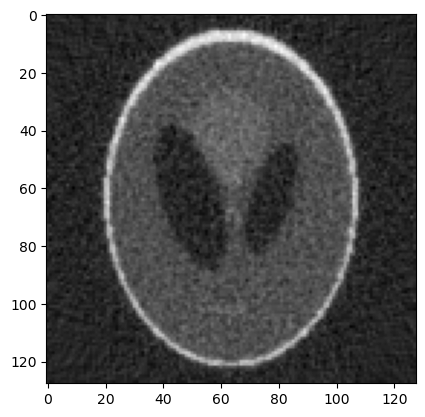

In [34]:
print(sol)
alpha = sol.x
gh, gw = g_noisy.shape
x_lsqr = solve_with_l2_reg(alpha, R_op, g_noisy.reshape((gh * gw)))
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

In [35]:
noise_matrix = g_noisy - grt
n = noise_matrix.shape[0] * noise_matrix.shape[1]
mu = np.sum(noise_matrix) / n
sig = np.sqrt(np.sum(np.power(noise_matrix - mu, 2)) / (n - 1))
print(mu, sig)
Af = apply_Radon_Matrix(R_op, f_rec_lsqr, 90, 128)
r_alpha_norm = np.linalg.norm(Af - g_noisy)
dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
print(dp_alpha)

0.006645027796427409 1.3568467199833762
-1.0323537580347875e-07


In [36]:
def construct_delta_xy(h, w):
    d = scipy.sparse.diags([1, -1], [0, 1], shape=(w, w))
    ri = np.eye(h)
    gx = scipy.sparse.kron(ri, d)
    gy = scipy.sparse.kron(d, ri)
    return gx, gy
def apply_gradient_to_image(g, im):
    h, w = im.shape
    imv = im.reshape((h * w,))
    gim = g @ imv
    return gim.reshape((h, w))

In [37]:
gx, gy = construct_delta_xy(128, 128)
gxa = gx.toarray()

In [61]:
def solve_with_l1_reg(alpha, A, g, h, w):
    gx, gy = construct_delta_xy(h, w)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [39]:
gh, gw = g_noisy.shape
x_lsqr = solve_with_l1_reg(10, R_op, g_noisy.reshape((gh * gw)), f_true.shape[0], f_true.shape[1])

Status: 2
Iteration number: 109

l2 distance:  12.125138033393215


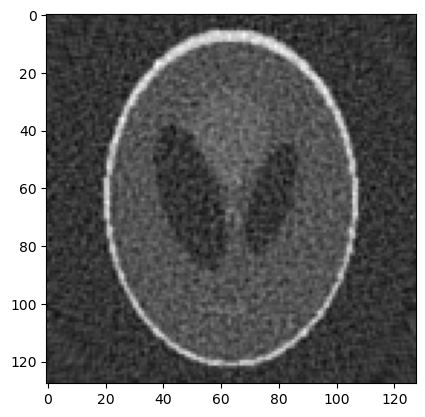

In [40]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(f_rec_lsqr, cmap='gray')

In [71]:
def dp_alpha_l1(alpha, sig, h, w, n_angles, n_projs):
    gh, gw = g_noisy.shape
    x_lsqr = solve_with_l1_reg(alpha.item(), R_op, g_noisy.reshape((gh * gw)), h, w)
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(R_op, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g_noisy)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return np.abs(dp_alpha)
sol = scipy.optimize.minimize_scalar(dp_alpha_l1, bounds=(1e-6, 1e3), 
                                     args=(sig, f_true.shape[0], f_true.shape[1], 90, 128), 
                                     method='bounded')
# sol = scipy.optimize.root(dp_alpha_l1, x0=100, args=(sig, f_true.shape[0], f_true.shape[1], 90, 128))

     fun: 9.509458793743875e-07
 message: 'Solution found.'
    nfev: 28
     nit: 28
  status: 0
 success: True
       x: 98.41826717490878
l2 distance:  11.787029224221113


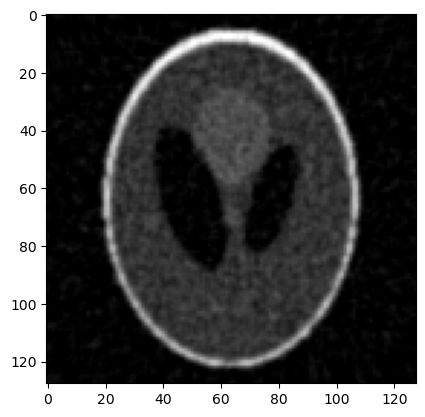

In [108]:
print(sol)
alpha = sol.x.item()
gh, gw = g_noisy.shape
x_lsqr = solve_with_l1_reg(alpha, R_op, g_noisy.reshape((gh * gw)), f_true.shape[0], f_true.shape[1])
f_rec_lsqr = x_lsqr[0].reshape((128, 128))
print('l2 distance: ', np.linalg.norm(f_rec_lsqr - f_true))
plt.imshow(np.clip(f_rec_lsqr, 0, 1), cmap='gray')

In [43]:
th = 100
tw = 50
tgx, tgy = construct_delta_xy(th, tw)
u = np.random.random((th * tw,))
v = np.random.random((th * tw,))
np.allclose(np.dot(tgy @ u, v), np.dot(u, tgy.T @ v))

True

#### 4. Write a Haar wavelet denoiser

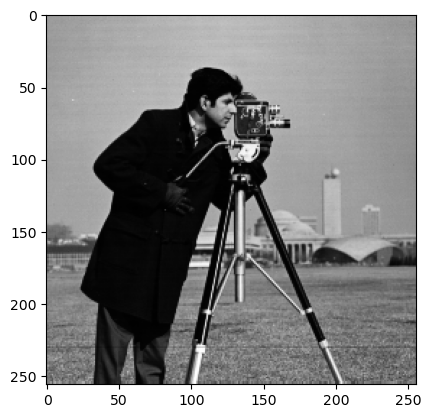

In [44]:
f_true = plt.imread('data/Cameraman256.png')
plt.imshow(f_true, cmap='gray')

43.73082352143584


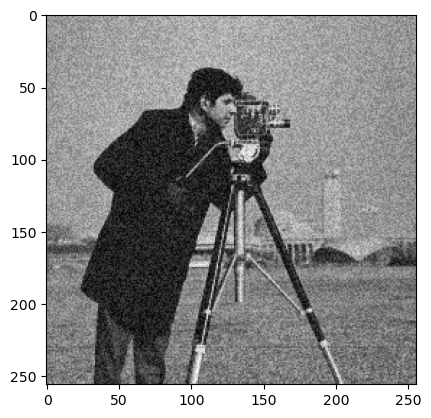

In [45]:
noiselevel = 0.3
immax = np.max(f_true)
f_noisy = f_true + noiselevel * immax * np.random.random(f_true.shape)
print(np.linalg.norm(f_noisy - f_true))
plt.imshow(f_noisy, cmap='gray')

In [85]:
def wavelet_decompose(data, wavelet_type, level):
    coeffs = pywt.wavedec2(data, wavelet_type, level=level)
    return coeffs

def wavelet_reconstruct(data, wavelet_type):
    f_rec = pywt.waverec2(data, wavelet_type)
    return f_rec

def extract_coeffs(coeffs):
    level = len(coeffs) - 1
    all_coeffs = []
    for i in range(1, level + 1):
        for c in coeffs[i]:
            all_coeffs.extend(c.flatten().tolist())
    all_coeffs = np.array(all_coeffs)
    non0_coeffs = all_coeffs[np.where(all_coeffs!=0)]
    abs_coeffs = np.abs(non0_coeffs)
    return non0_coeffs[np.argsort(abs_coeffs)]

def determine_abs_threshold(x, coeffs):
    non0_coeffs = extract_coeffs(coeffs)
    cn = non0_coeffs.shape[0]
    return np.abs(non0_coeffs[int(cn * x)])

def threshold_coeffs(coeffs, threshold, level, threshold_fucntion=None):
    new_coeffs = ()
    for c in coeffs[level]:
        if threshold_fucntion:
            new_coeffs += (threshold_fucntion(c, threshold),)
        else:
            new_coeffs += (pywt.threshold(c, threshold, mode='garrote', substitute=0),)
    coeffs[level] = new_coeffs

def threshold_specific_levels(coeffs, threshold, levels, threshold_fucntion=None):
    for level in levels:
        threshold_coeffs(coeffs, threshold, level, threshold_fucntion)

def visualize_coeffs(coeffs):
    A = coeffs[0]
    for coeff in coeffs[1:]:
        A = np.vstack((np.hstack((A, coeff[0])), np.hstack((coeff[1], coeff[2]))))
    plt.imshow(A, cmap='gray')
    return A

In [47]:
level = 5
coeffs = pywt.wavedec2(f_noisy, 'db4', level=level)
print(coeffs[0].shape)
for it in coeffs[1:]:
    for iit in it:
        print(iit.shape)

(14, 14)
(14, 14)
(14, 14)
(14, 14)
(22, 22)
(22, 22)
(22, 22)
(38, 38)
(38, 38)
(38, 38)
(69, 69)
(69, 69)
(69, 69)
(131, 131)
(131, 131)
(131, 131)


In [86]:
level = 5
coeffs = pywt.wavedec2(f_noisy, 'db4', level=level)
# visualize_coeffs(coeffs)
threshold = determine_abs_threshold(0.8, coeffs)
levels = range(1, level + 1)
# levels = [1]
threshold_specific_levels(coeffs, threshold, levels)
f_rec = np.clip(pywt.waverec2(coeffs, 'db4'), 0, 1)
print(np.linalg.norm(f_rec - f_true))
print(f_rec.shape)
plt.imshow(f_rec, cmap='gray')

ValueError: operands could not be broadcast together with shapes (256,256) (128,128) 

#### 5. Iterative soft-thresholding for X-ray tomography

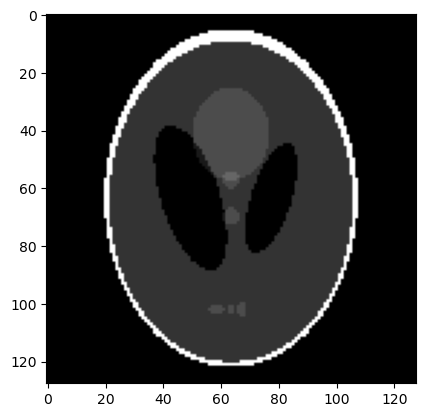

In [73]:
f_true = SLphantom
plt.imshow(f_true, cmap='gray')

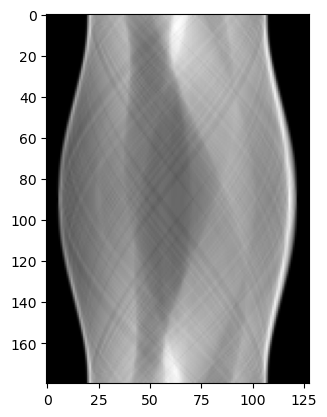

In [148]:
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, 128, 180)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(grt, cmap='gray')

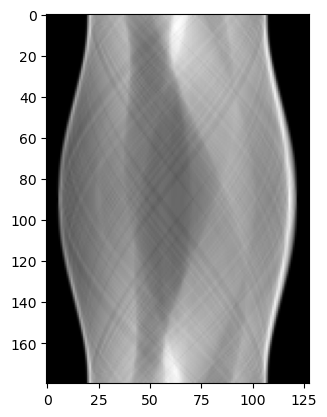

In [152]:
R_op = construct_Radon_Operator(128, 128, 128, 180, np.pi)
plt.imshow(apply_Radon_Matrix(R_op, f_true, 180, 128), cmap='gray')

In [266]:
u, s, vh = scipy.sparse.linalg.svds(R_op, k=1, which='LM')
lam = 1.5 / s.item() / s.item()
alpha = 0.5
mu = alpha * lam
print(lam, alpha, mu)

6.805820969637916e-05 0.5 3.402910484818958e-05


In [77]:
a = np.array([
    [1, 2, 3],
    [-1, -2, -3],
    [0, 0, 0]
])
b = a.copy()
b[np.abs(a)<2]=100
print(b)

[[100   2   3]
 [100  -2  -3]
 [100 100 100]]


In [225]:
def soft_threshold(data, alpha):
    data_copy = data.copy()
    data_copy[data>=alpha] -= alpha
    data_copy[np.abs(data)<alpha] = 0
    data_copy[data<=-alpha] += alpha
    return data_copy

def ISTA(A, g, h, w, lam, alpha, it_num=100, wavelet_type='db4', level=5):
    mu = lam * alpha
    
    f_old = A.T @ g
    f_old = f_old - np.min(f_old)
    f_old = f_old / np.max(f_old)
    f_old = np.power(f_old, 3)
    for i in tqdm(range(it_num)):
        f_new = f_old - lam * A.T @ (A @ f_old - g)
        coeffs = wavelet_decompose(f_new.reshape((h, w)), wavelet_type, level)
        threshold_specific_levels(coeffs, mu, range(1, level + 1), soft_threshold)
        f_old = wavelet_reconstruct(coeffs, wavelet_type).reshape((h * w))
    
    return f_old.reshape((h, w))

0.0 1.0


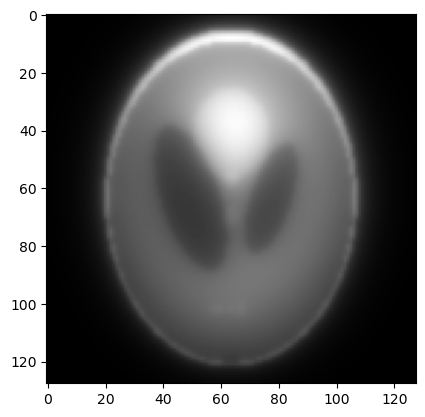

In [224]:
backp = (R_op.T @ grt.flatten()).reshape((128, 128))
backp = backp - np.min(backp)
backp = backp / np.max(backp)
print(np.min(backp), np.max(backp))
backp = np.power(backp, 3)
plt.imshow(backp, cmap='gray')

In [269]:
f_rec = ISTA(R_op, grt.flatten(), 128, 128, lam, alpha, it_num=1000)

100%|██████████| 100/100 [00:07<00:00, 14.03it/s]


l2 distance:  7.021847355072326


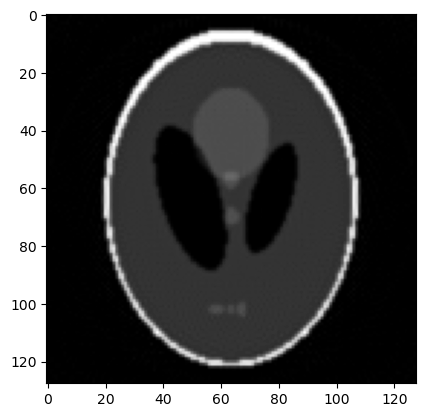

In [270]:
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')